In [1]:
# Imports
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import warnings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

if not tf.test.gpu_device_name():
    warnings.warn("No GPU found.")
else: 
    print('Default gpu device: {}' .format(tf.test.gpu_device_name()))

gpus = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Default gpu device: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


2023-05-30 09:06:35.032133: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 09:06:35.103055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-30 09:06:35.106172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-30 09:06:35.106275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [2]:
def load_data(filename, resample=False, integer_timestamp=False):
    # Load in the data
    df = pd.read_csv(filename, parse_dates=['timestamp'])
    
    # drop nan values
    df = df.dropna()

    # set timestamp as index and drop timestamp column
    df.index = pd.to_datetime(df['timestamp'], format='%Y.%m.%d %H:%M:%S')
    df = df.drop(columns=['timestamp'])

    if(resample):
        # Resample the DataFrame to 4 minutes frequency if needed
        df = df.resample('4T').mean()
    if(integer_timestamp):
        # use if the timestamp is a integer
        to_datetime = lambda x: datetime.datetime.fromtimestamp(x/1000.0)
        df['timestamp'] = df['timestamp'].astype(float)
        df['timestamp'] = df['timestamp'].apply(to_datetime)


    return df

df_laptop = load_data(r'../csv_files/prediction_data/pc_jarno_4w_allsame.csv')
df_box = load_data(r'../csv_files/prediction_data/synthetic_test_4w_allsame.csv')
df_pc = load_data(r'../csv_files/prediction_data/PCSynth.csv')
df_printer = load_data(r'../csv_files/prediction_data/PrinterSynth.csv')
df_phone = load_data(r'../csv_files/prediction_data/PhoneSynth.csv')


def add_time_features(df):
    # add hour, minute, day of the week and month parameters
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    # df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    # df['month'] = df.index.month
    return df

# Create a list of dataframes
dfs = [df_box, df_laptop, df_pc, df_phone, df_printer]

# Iterate over the dataframes
for i, df in enumerate(dfs):
    # Add time features to each dataframe
    df = add_time_features(df)
    # Reset the index of each dataframe
    df = df.reset_index()
    # Assign a new column value 'device'
    df['device'] = i
    # Update the dataframe in the list
    dfs[i] = df

# Concatenate the modified dataframes into a single dataframe
combined_df = pd.concat(dfs)

# Drop the 'timestamp' column
combined_df = combined_df.drop(columns=['timestamp'])



print(combined_df)
# print("done")
print(dfs[1])
dfs[0].head()

       state  hour  minute  day_of_week  device
0        0.0     0       0            0       0
1        0.0     0       4            0       0
2        0.0     0       8            0       0
3        0.0     0      12            0       0
4        0.0     0      16            0       0
...      ...   ...     ...          ...     ...
10075    0.0    23      40            6       4
10076    0.0    23      44            6       4
10077    0.0    23      48            6       4
10078    0.0    23      52            6       4
10079    0.0    23      56            6       4

[50400 rows x 5 columns]
                timestamp  state  hour  minute  day_of_week  device
0     2023-01-02 00:00:00      1     0       0            0       1
1     2023-01-02 00:04:00      1     0       4            0       1
2     2023-01-02 00:08:00      1     0       8            0       1
3     2023-01-02 00:12:00      1     0      12            0       1
4     2023-01-02 00:16:00      1     0      16            

,timestamp,state,hour,minute,day_of_week,device
0,2023-01-02 00:00:00,0.0,0,0,0,0
1,2023-01-02 00:04:00,0.0,0,4,0,0
2,2023-01-02 00:08:00,0.0,0,8,0,0
3,2023-01-02 00:12:00,0.0,0,12,0,0
4,2023-01-02 00:16:00,0.0,0,16,0,0


In [3]:
# # add column for state
# df['state'] = np.where(df['power'] > 5, 1, 0)
# # df['state'] = np.where(df['power'] > 50, 1, 0)
# df = df.drop(columns=['power']) # not sure if power is a valuable parameter

In [4]:
combined_df.head()

,state,hour,minute,day_of_week,device
0,0.0,0,0,0,0
1,0.0,0,4,0,0
2,0.0,0,8,0,0
3,0.0,0,12,0,0
4,0.0,0,16,0,0


In [5]:
combined_df.describe()

,state,hour,minute,day_of_week,device
count,50400.000000,50400.000000,50400.000000,50400.00000,50400.000000
mean,0.345952,11.500000,28.000000,3.00000,2.000000
std,0.475682,6.922255,17.282147,2.00002,1.414228
min,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,5.750000,12.000000,1.00000,1.000000
50%,0.000000,11.500000,28.000000,3.00000,2.000000
75%,1.000000,17.250000,44.000000,5.00000,3.000000
max,1.000000,23.000000,56.000000,6.00000,4.000000


In [6]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Drop the 'timestamp' column from each dataframe
for df in dfs:
  df.drop(columns=['timestamp'], inplace=True)

# normalize our features, scale on all values first (combined)
scaler = MinMaxScaler(feature_range=(-1,1))
combined_df[['hour','minute','day_of_week', 'device']] = scaler.fit_transform(combined_df[['hour','minute','day_of_week','device']])

# Scale the separate dataframes
for df in dfs:
  df[['hour', 'minute', 'day_of_week', 'device']] = scaler.transform(df[['hour', 'minute', 'day_of_week', 'device']])


joblib.dump(scaler, './scaler_boxpc.gz') # save the scaler

# Print the dataframes
for df in dfs:
  print(df)

       state  hour    minute  day_of_week  device
0        0.0  -1.0 -1.000000         -1.0    -1.0
1        0.0  -1.0 -0.857143         -1.0    -1.0
2        0.0  -1.0 -0.714286         -1.0    -1.0
3        0.0  -1.0 -0.571429         -1.0    -1.0
4        0.0  -1.0 -0.428571         -1.0    -1.0
...      ...   ...       ...          ...     ...
10075    1.0   1.0  0.428571          1.0    -1.0
10076    1.0   1.0  0.571429          1.0    -1.0
10077    0.0   1.0  0.714286          1.0    -1.0
10078    0.0   1.0  0.857143          1.0    -1.0
10079    0.0   1.0  1.000000          1.0    -1.0

[10080 rows x 5 columns]
       state  hour    minute  day_of_week  device
0          1  -1.0 -1.000000         -1.0    -0.5
1          1  -1.0 -0.857143         -1.0    -0.5
2          1  -1.0 -0.714286         -1.0    -0.5
3          1  -1.0 -0.571429         -1.0    -0.5
4          1  -1.0 -0.428571         -1.0    -0.5
...      ...   ...       ...          ...     ...
10075      0   1.0  0.42

In [7]:
def split_train_test(df):
    train_size = int(len(df) * 0.6)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
    return train, test


# split the datasets into training and testing sets
train_box, test_box = split_train_test(dfs[0])

train, test = split_train_test(dfs[1])
# train_sille, test_sille = split_train_test(df_generated2)
train_pc, test_pc = split_train_test(dfs[2])
train_phone, test_phone = split_train_test(dfs[3])
train_printer, test_printer = split_train_test(dfs[4])

# print the size of the training and testing sets for each dataset
print(train, test)
# print(len(train_sille), len(test_sille))
print(len(train_box), len(test_box))
print(len(train_pc), len(test_pc))
print(len(train_printer), len(test_printer))
print(len(train_phone), len(test_phone))

train = train.astype(float)

      state      hour    minute  day_of_week  device
0         1 -1.000000 -1.000000    -1.000000    -0.5
1         1 -1.000000 -0.857143    -1.000000    -0.5
2         1 -1.000000 -0.714286    -1.000000    -0.5
3         1 -1.000000 -0.571429    -1.000000    -0.5
4         1 -1.000000 -0.428571    -1.000000    -0.5
...     ...       ...       ...          ...     ...
6043      1  0.565217  0.857143    -0.333333    -0.5
6044      1  0.565217  1.000000    -0.333333    -0.5
6045      1  0.652174 -1.000000    -0.333333    -0.5
6046      1  0.652174 -0.857143    -0.333333    -0.5
6047      1  0.652174 -0.714286    -0.333333    -0.5

[6048 rows x 5 columns]        state      hour    minute  day_of_week  device
6048       1  0.652174 -0.571429    -0.333333    -0.5
6049       1  0.652174 -0.428571    -0.333333    -0.5
6050       1  0.652174 -0.285714    -0.333333    -0.5
6051       1  0.652174 -0.142857    -0.333333    -0.5
6052       1  0.652174  0.000000    -0.333333    -0.5
...      ...   

In [8]:
train.shape, test.shape

((6048, 5), (4032, 5))

In [9]:
def create_dataset(input, output, time_steps=1):
    x,y = [], []
    # print("this is the output",output)
    # print("this is the input",input)
    for i in range(len(input) - time_steps):
        # print(i)
        v = input.iloc[i:(i + time_steps)].values
        x.append(v)
        y.append(output.iloc[i + time_steps])
    return np.array(x), np.array(y)

      state      hour    minute  day_of_week  device
0         0 -1.000000 -1.000000    -1.000000     0.5
1         0 -1.000000 -0.857143    -1.000000     0.5
2         0 -1.000000 -0.714286    -1.000000     0.5
3         0 -1.000000 -0.571429    -1.000000     0.5
4         0 -1.000000 -0.428571    -1.000000     0.5
...     ...       ...       ...          ...     ...
6043      1  0.565217  0.857143    -0.333333     0.5
6044      1  0.565217  1.000000    -0.333333     0.5
6045      1  0.652174 -1.000000    -0.333333     0.5
6046      1  0.652174 -0.857143    -0.333333     0.5
6047      1  0.652174 -0.714286    -0.333333     0.5

[6048 rows x 5 columns]
(17640, 2520, 5) (7560, 2520, 5) (17640,) (7560,)
[[[ 1.         -1.         -1.         -1.         -0.5       ]
  [ 1.         -1.         -0.85714286 -1.         -0.5       ]
  [ 1.         -1.         -0.71428571 -1.         -0.5       ]
  ...
  [ 0.          1.          0.71428571  1.         -0.5       ]
  [ 0.          1.         

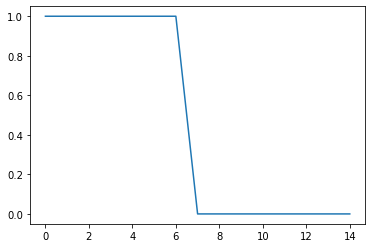

In [10]:
time_steps = 2520 # 4 minutes for 1 week = 2520, 1 hour 168, 30 minutes 336, 15 minutes 672

from sklearn import preprocessing

dataframes = [train, train_box, train_pc, train_printer, train_phone]
test_dataframes = [test, test_box, test_pc, test_printer, test_phone]
print(dataframes[i])

train = [None] * (len(dataframes) * 2)
test = [None] * (len(dataframes) * 2)

for i in range(len(dataframes)):
    train[i*2],train[(i*2)+1] = create_dataset(dataframes[i],dataframes[i].state,time_steps)
    test[i*2],test[(i*2)+1] = create_dataset(test_dataframes[i],test_dataframes[i].state,time_steps)


# concatenate the different training and test sets with eachother
input_train_conc = np.concatenate((train[0],train[2],train[4],train[6],train[8]),axis=0)
input_test_conc = np.concatenate((test[0],test[2],test[4],test[6],test[8]),axis=0)
output_train_conc = np.concatenate((train[1],train[3],train[5],train[7],train[9]),axis=0)

plt.plot(output_train_conc[25:40])
# determines with how munch the values should minimaly be changed
min_slope = 0.2
# percentage of previous values to update
pct_prev_vals = 0.5
# counts how long ago the last edge occured
last_change = 1
# the first value
previous = output_train_conc[0]

for i in range(1,len(output_train_conc)):
    # if an edge is detected
    if(output_train_conc[i] != previous):
        # calculate the number of previous values to update based on the percentage and maximum limit
        num_prev_vals = min(int(pct_prev_vals * last_change), 4)
        # calculate the slope based on the number of previous values being updated
        slope = min(min_slope * (4 // num_prev_vals),0.3)
        for j in range(1,num_prev_vals+1):
            if(output_train_conc[i] == 1): # if the value changes to 1
                # replace the value with its new value
                # this is calculated based on the slope times how far the value is from the edge
                output_train_conc[i - j] += slope*((num_prev_vals+1)-j) 
            else: # if the value changes to 0
                output_train_conc[i - j] -= slope*((num_prev_vals+1)-j)
        last_change = 1
    else:
        last_change += 1
    previous = output_train_conc[i] # store the last value


output_test_conc = np.concatenate((test[1],test[3],test[5],test[7],test[9]),axis=0)
print(input_train_conc.shape, input_test_conc.shape, output_train_conc.shape, output_test_conc.shape)

print(input_train_conc)

In [11]:
model = Sequential()
model.add(Bidirectional(LSTM(8, input_shape=(input_train_conc.shape[1],input_train_conc.shape[2]),return_sequences=True,activation='tanh')))# , input_shape=(input_train.shape[1],input_train.shape[2]), return_sequences=True)
model.add(Dropout(0.25))
model.add(
    Bidirectional(LSTM(2,activation='tanh',recurrent_dropout=0))
)
model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001), metrics= ["accuracy"])

In [12]:
history = model.fit(input_train_conc, output_train_conc, epochs=5,batch_size=32)
model.summary()

2023-05-30 09:06:41.007240: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2023-05-30 09:06:43.851805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


  1/552 [..............................] - ETA: 31:26 - loss: 0.6657 - accuracy: 0.7188

2023-05-30 09:06:44.296500: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


552/552 [==============================] - 82s 142ms/step - loss: 0.2362 - accuracy: 0.9422
Epoch 2/5
552/552 [==============================] - 80s 144ms/step - loss: 0.0547 - accuracy: 0.9723
Epoch 3/5
552/552 [==============================] - 79s 142ms/step - loss: 0.0372 - accuracy: 0.9724
Epoch 4/5
552/552 [==============================] - 79s 143ms/step - loss: 0.0307 - accuracy: 0.9724
Epoch 5/5
552/552 [==============================] - 79s 143ms/step - loss: 0.0279 - accuracy: 0.9726
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2520, 16)          896       
_________________________________________________________________
dropout (Dropout)            (None, 2520, 16)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4)                 304       
__________________

In [13]:
# make predictions for input data
prediction = model.predict(input_test_conc)

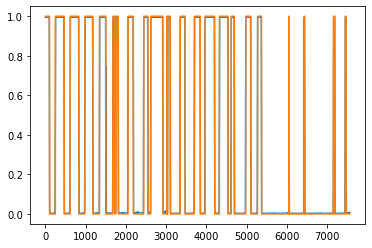

In [14]:
# compare prediction to expected output (output without rounded edges)
plt.plot(prediction)
plt.plot(output_test_conc)

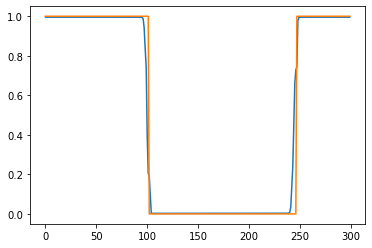

In [15]:
# zoom in on part of plot
plt.plot(prediction[0:300])
plt.plot(output_test_conc[0:300])

In [16]:
# save model
model.save('./saved_models/models_day_month/all_devices_test/')

2023-05-30 09:13:39.254837: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_models/models_day_month/all_devices_test/assets


INFO:tensorflow:Assets written to: ./saved_models/models_day_month/all_devices_test/assets


In [17]:
# save model in tar.gz
!tar chvfz models_day_month.tar.gz ./saved_models/models_day_month*

./saved_models/models_day_month/
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/keras_metadata.pb
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/saved_model.pb
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/assets/
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/variables/
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/variables/variables.index
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/variables/variables.data-00000-of-00001
./saved_models/models_day_month/all_devicesV3/
./saved_models/models_day_month/all_devicesV3/keras_metadata.pb
./saved_models/models_day_month/all_devicesV3/saved_model.pb
./saved_models/models_day_month/all_devicesV3/assets/

In [18]:
# make a backup of the entire server
# !tar chvfz jupyter_backup.tar.gz ../../../shared/
!tar chvfz notebook_backup.tar.gz ./prediction_state_day_month-softmax-Copy2.ipynb

./prediction_state_day_month-softmax-Copy2.ipynb
